# 1. Install and Import Dependencies

In [13]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
from copy import deepcopy

# 2. Load Model

In [14]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5n')

Using cache found in /home/cc/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-8 Python-3.8.13 torch-1.7.0 CUDA:0 (Quadro RTX 6000, 24220MiB)

100%|██████████| 3.87M/3.87M [00:00<00:00, 14.7MB/s]

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 


In [15]:
model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  

# 3. Make Detections with Images

In [17]:
img = 'https://ultralytics.com/images/zidane.jpg'

In [18]:
results = model(img)
results.print()

image 1/1: 720x1280 2 persons, 1 tie
Speed: 289.9ms pre-process, 9.4ms inference, 2.3ms NMS per image at shape (1, 3, 384, 640)


In [6]:
type(results)

models.common.Detections

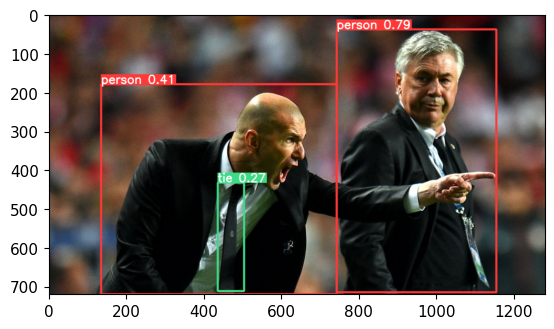

In [7]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [8]:
cropped_results = results.crop()

Saved 1 image to runs/detect/exp
Saved results to runs/detect/exp



In [9]:
type(cropped_results)

list

In [ ]:
selected_keys = ['label', 'im']
lst = [
    {key:value for key,value in result.items() if key in selected_keys}
    for result in cropped_results]
lst

In [ ]:
for item in lst:
    item['im'] = item['im'].tolist()

lst

In [13]:
data_folder_path = '/home/cc/my_mounting_point/datasets'
dataset_folder_path = os.path.join(
    data_folder_path, 'ILSVRC/Data/DET/test'
)
classes_file_path = os.path.join(
    data_folder_path, 'imagenet_classes.txt'
)

image_names = os.listdir(dataset_folder_path)
image_names.sort()
with open(classes_file_path) as f:
    classes = [line.strip() for line in f.readlines()]

def image_loader(folder_path, image_name):
    image = Image.open(
        os.path.join(folder_path, image_name))
    # if there was a need to filter out only color images
    # if image.mode == 'RGB':
    #     pass
    return image
num_loaded_images = 17
images = {
    image_name: image_loader(
        dataset_folder_path, image_name) for image_name in image_names[
            :num_loaded_images]}

In [ ]:
images

In [15]:
model_results = {}
for image_name, image in images.items():
    model_results[image_name] = model(np.array(image))

In [ ]:
for image_name, image in images.items():
    print(image_name)
    print(np.array(image).shape)
    print(np.array(image).dtype)

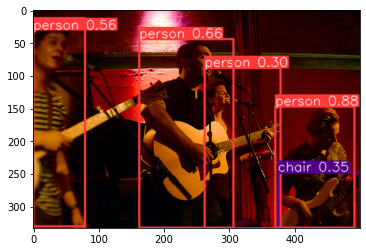

In [17]:
%matplotlib inline
image_num = 1
plt.imshow(np.squeeze(list(model_results.items())[8][image_num].render()))
plt.show()


In [22]:
def get_cropped(result):
    """
    crops selected objects for
    the subsequent nodes
    """
    result = result.crop()
    liscense_labels = ['car', 'truck']
    car_labels = ['car']
    person_labels = ['person']
    output_list = {'person': [], 'car': [], 'liscense': []}
    for obj in result:
        for label in liscense_labels:
            if label in obj['label']:
                output_list['liscense'].append(deepcopy(obj['im']))
                break
        for label in car_labels:
            if label in obj['label']:
                output_list['car'].append(deepcopy(obj['im']))
                break
        for label in person_labels:
            if label in obj['label']:
                output_list['person'].append(deepcopy(obj['im']))
                break
    return output_list

In [23]:
crop_results = {}
for image_name, result in model_results.items():
    crop_results[image_name] = get_cropped(result)

NameError: name 'model_results' is not defined

In [7]:
crop_results

{}

In [8]:
len(list(crop_results.items())[8][1]['person'])

IndexError: list index out of range

In [ ]:
%matplotlib inline
image_num = 1
plt.imshow(list(crop_results.items())[2][image_num]['person'][0])
plt.show()

In [21]:
list(crop_results.items())[2][image_num]['person'][0].shape

IndexError: list index out of range

In [19]:
import os
import numpy as np
import torch
from torchvision import models
from torchvision import transforms

def predict(X, features_names=None):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
    X_trans = Image.fromarray(X.astype(np.uint8))
    X_trans = transform(X_trans)
    batch = torch.unsqueeze(X_trans, 0)
    resnet = models.resnet101(pretrained=True)
    resnet.eval()
    out = resnet(batch)
    percentages = torch.nn.functional.softmax(out, dim=1)[0] * 100
    percentages = percentages.detach().numpy()
    image_net_class = np.argmax(percentages)
    return image_net_class


In [20]:
import os
import numpy as np
import torch
from torchvision import models
from torchvision import transforms

def predict(X, features_names=None):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
    if X['person'] == []:
        return []
    X = X['person']
    X_trans = [transform(Image.fromarray(image)) for image in X]
    batch = torch.stack(X_trans, axis=0)
    # batch = torch.unsqueeze(X_trans, 0)
    resnet = models.resnet101(pretrained=True)
    resnet.eval()
    out = resnet(batch)
    percentages = torch.nn.functional.softmax(out, dim=1) * 100
    percentages = percentages.detach().numpy()
    image_net_class = np.argmax(percentages, axis=1)
    return image_net_class.tolist()

image_num = 8

predict(list(crop_results.items())[image_num][1]['person'])

IndexError: list index out of range

In [2]:
a = model(np.array(images['ILSVRC2017_test_00000001.JPEG'], dtype=float))

NameError: name 'model' is not defined

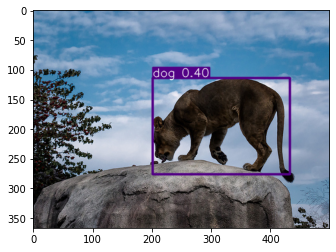

In [ ]:
%matplotlib inline
plt.imshow(np.squeeze(a.render()))
plt.show()

In [ ]:
np.array(np.array(images['ILSVRC2017_test_00000001.JPEG'], dtype=float), dtype=np.uint8).dtype

In [ ]:
np.array(images['ILSVRC2017_test_00000001.JPEG']).dtype

In [ ]:
image_num = 1
list(crop_results.items())[2][image_num]['person'][0]

In [ ]:
list(crop_results.items())[image_num][1]

In [81]:
len(list(crop_results.items())[8][1]['person'])

4

In [ ]:
list(crop_results.items())[image_num][1]['person']

# Test Batching

In [3]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5l')

/home/cc/miniconda3/envs/central/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/cc/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-14 Python-3.8.13 torch-1.11.0+cu102 CPU

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


In [12]:
import os
from PIL import Image
import numpy as np


os.system('sudo umount -l ~/my_mounting_point')
os.system('cc-cloudfuse mount ~/my_mounting_point')

data_folder_path = '/home/cc/my_mounting_point/datasets'
dataset_folder_path = os.path.join(
    data_folder_path, 'ILSVRC/Data/DET/test'
)
classes_file_path = os.path.join(
    data_folder_path, 'imagenet_classes.txt'
)

image_names = os.listdir(dataset_folder_path)
image_names.sort()
with open(classes_file_path) as f:
    classes = [line.strip() for line in f.readlines()]
num_loaded_images = 10

def image_loader(folder_path, image_name):
    image = Image.open(
        os.path.join(folder_path, image_name))
    # if there was a need to filter out only color images
    # if image.mode == 'RGB':
    #     pass
    return image

images = {
    image_name: image_loader(
        dataset_folder_path, image_name) for image_name in image_names[
            :num_loaded_images]}

umount: /home/cc/my_mounting_point: not mounted.
Failed to authenticate.


FileNotFoundError: [Errno 2] No such file or directory: '/home/cc/my_mounting_point/datasets/ILSVRC/Data/DET/test'

In [27]:
batched_input = list(map(lambda l: np.array(l), images.values()))
result = model(batched_input)


In [31]:
# np.alltrue(result.imgs[0] == list(images.values())[0])
result.tolist()[1].crop(save=False)

[{'box': [tensor(96.84126),
   tensor(102.18723),
   tensor(373.15277),
   tensor(369.54523)],
  'conf': tensor(0.49124),
  'cls': tensor(57.),
  'label': 'couch 0.49',
  'im': array([[[  0,   0,   1],
          [  0,   0,   1],
          [  0,   0,   1],
          ...,
          [ 60,  53,  50],
          [ 60,  53,  50],
          [ 58,  53,  52]],
  
         [[ 60,  58,  58],
          [ 62,  60,  59],
          [ 72,  70,  69],
          ...,
          [ 59,  52,  49],
          [ 60,  53,  50],
          [ 58,  53,  52]],
  
         [[ 87,  86,  90],
          [ 87,  86,  90],
          [ 90,  89,  93],
          ...,
          [ 60,  53,  50],
          [ 60,  53,  50],
          [ 58,  53,  52]],
  
         ...,
  
         [[  0,   5,  20],
          [  7,  11,  29],
          [ 15,  20,  41],
          ...,
          [ 84, 100, 117],
          [ 84,  98, 116],
          [ 92, 106, 125]],
  
         [[  0,   4,  19],
          [  5,   9,  27],
          [ 14,  19,  40],
   

In [23]:
from copy import deepcopy

def get_cropped(result):
    """
    crops selected objects for
    the subsequent nodes
    """
    output_list = []
    for res in result.tolist():
        res = res.crop()
        liscense_labels = ['car', 'truck']
        car_labels = ['car']
        person_labels = ['person']
        res_output = {'person': [], 'car': [], 'liscense': []}
        for obj in res:
            for label in liscense_labels:
                if label in obj['label']:
                    res_output['liscense'].append(deepcopy(obj['im']))
                    break
            for label in car_labels:
                if label in obj['label']:
                    res_output['car'].append(deepcopy(obj['im']))
                    break
            for label in person_labels:
                if label in obj['label']:
                    res_output['person'].append(deepcopy(obj['im']))
                    break
        output_list.append(res_output)
    return output_list
output_list = get_cropped(result)

Saved 1 image to runs/detect/exp2
Saved results to runs/detect/exp2

Saved 1 image to runs/detect/exp3
Saved results to runs/detect/exp3

Saved 1 image to runs/detect/exp4
Saved results to runs/detect/exp4

Saved 1 image to runs/detect/exp5
Saved results to runs/detect/exp5

Saved 1 image to runs/detect/exp6
Saved results to runs/detect/exp6

Saved 1 image to runs/detect/exp7
Saved results to runs/detect/exp7

Saved 1 image to runs/detect/exp8
Saved results to runs/detect/exp8

Saved 1 image to runs/detect/exp9
Saved results to runs/detect/exp9

Saved 1 image to runs/detect/exp10
Saved results to runs/detect/exp10

Saved 1 image to runs/detect/exp11
Saved results to runs/detect/exp11



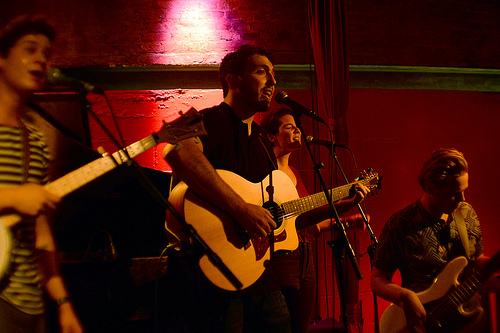

In [25]:
images['ILSVRC2017_test_00000009.JPEG']

In [66]:
image = np.array(list(images.values())[0])
print(f"type:\n{type(image)}")
print(f"type:\n{type(image[0][0][0])}")
print(f"shape:\n{image.shape}")
model(image.astype(int))

type:
<class 'numpy.ndarray'>
type:
<class 'numpy.uint8'>
shape:
(367, 500, 3)


error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:3930: error: (-215:Assertion failed) func != 0 in function 'resize'


In [65]:
image.astype(int)

array([[[108, 146, 183],
        [115, 153, 190],
        [112, 148, 184],
        ...,
        [121, 151, 185],
        [124, 154, 188],
        [124, 154, 188]],

       [[108, 148, 184],
        [108, 146, 183],
        [107, 145, 182],
        ...,
        [123, 152, 186],
        [126, 155, 187],
        [125, 154, 186]],

       [[109, 148, 187],
        [104, 143, 182],
        [105, 145, 181],
        ...,
        [128, 152, 186],
        [129, 155, 188],
        [126, 155, 187]],

       ...,

       [[ 42,  43,  45],
        [ 43,  43,  45],
        [ 45,  41,  42],
        ...,
        [155, 153, 174],
        [170, 168, 189],
        [134, 133, 149]],

       [[ 68,  69,  71],
        [ 63,  63,  65],
        [ 45,  41,  42],
        ...,
        [146, 151, 171],
        [163, 168, 187],
        [175, 181, 195]],

       [[ 39,  40,  42],
        [ 39,  39,  41],
        [ 51,  47,  48],
        ...,
        [140, 142, 163],
        [164, 165, 185],
        [180, 184, 196]]